# Workbook for testing and documenting the Python Algorithms
> After finalizign algorithm here, it will be added to the main project under streamlit so it runs natively on the backend

In [4]:
import math
import numpy as np
import yfinance as yf
from time import time
from functools import wraps
import matplotlib.pyplot as plt

In [5]:
def calc_runtime(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        end_time = time()
        print(f"{func.__name__}({args, kwargs}) executed in ", end="")
        print(f"{end_time - start_time:.6f} seconds")
        return result
    return wrapper

# Initialize input data

In [12]:
S0 = 100.0     # Initial Stock Price
K = 110.0      # Strike Price
r = 0.06      # Risk-free interest rate
T = 2          # Time to maturity in years
N = 2000        # Number of time steps
vol = 0.2      # Volatility of the underlying stock (user input)
opttype = "C"  # "C" for Call, "P" for Put  
optclass = "E" # European or American option


# CRR values
### Calculating the up (up) and down (d) values using volatility (σ)

## CRR using infered σ from u and d

In [7]:
# u and d inferered from CRR model

## CRR using implied σ
> found by reverse calculating σ from option market price

In [8]:
# connect too Yahoo Finance to get stock/option data
def implied_volatility(symbol, S0, K, r, T, market_price, opttype):
    # Function to calculate implied volatility
    pass  # Implementation goes here

def crr_up_down(vol, dt):
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    return u, d

# Binmoial Method Algorithm

### Python Dynamic Programming

In [9]:
@calc_runtime
def binomial_option_price_dp(S0, K, T, r, N, u, d, opttype='C', optclass="E") -> float:
    """
    This algorithm uses dynamic programming to store option values at each node,
    iteratively calculating values from maturity back to the present.

    Only stores one layer of option values at a time to optimize space.

    Complexity:
    Time: O(N^2)
    Space: O(N)

    Parameters:
    S0 : float : Initial stock price
    K : float : Strike price
    T : float : Time to maturity in years
    r : float : Risk-free interest rate
    N : int : Number of time steps
    u : float : Up factor per time step
    d : float : Down factor per time step
    opttype : str : 'C' for Call option, 'P' for Put option
    optclass : str : 'E' for European option, 'A' for American option
    """

    dt = T / N
    q = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    # Initialize asset prices at maturity
    S = np.zeros(N + 1) # [0, 0, .. N]
    S[0] = S0 * (d ** N) # [S0, 0, .. N]

    # Build the asset price tree
    for up_move in range(1, N+1):
        # Going up the tree
        S[up_move] = S[up_move - 1] * (u / d)

    # Initialize option values at maturity
    option_values = np.zeros(N + 1) # [0, 0, .. N]
    for up_move in range(N + 1):
        if opttype == 'C':
            option_values[up_move] = max(0, S[up_move] - K)
        else:
            option_values[up_move] = max(0, K - S[up_move])

    # Backward induction
    for step in range(N - 1, -1, -1):
        for up_move in range(step + 1):
            option_values[up_move] = discount * (q * option_values[up_move + 1] + (1 - q) * option_values[up_move]) # binomial formula
            if optclass == "A":
                # American option early exercise check
                if opttype == 'C':
                    option_values[up_move] = max(
                        option_values[up_move], 
                        S0 * (u ** up_move) * (d ** (step - up_move)) - K
                        )
                else:
                    option_values[up_move] = max(
                        option_values[up_move], 
                        K - S0 * (u ** up_move) * (d ** (step - up_move))
                        )
            else:
                pass  # European option, no early exercise

    return np.round(option_values[0], 3)

### NumPy Vectorization

In [ ]:
@calc_runtime
def binomial_option_price_npv(S0, K, T, r, N, u, d, opttype='C', optclass="E") -> float:
    """
    TBD
    """
    return 0.0

## Tests

In [13]:
print(binomial_option_price_dp(S0, K, T, r, N, *crr_up_down(vol, T / N), opttype, optclass))

binomial_option_price_dp(((100.0, 110.0, 2, 0.06, 2000, np.float64(1.00634459755079), np.float64(0.9936954025825434), 'C', 'E'), {})) executed in 0.570975 seconds
12.371


## Black-Scholes Convergence

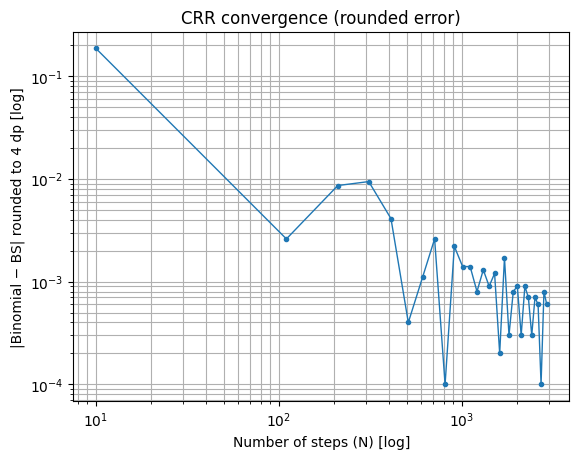

In [54]:
def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def bs_price(S0, K, r, T, vol, opttype="C"):
    d1 = (math.log(S0 / K) + (r + 0.5 * vol**2) * T) / (vol * math.sqrt(T))
    d2 = d1 - vol * math.sqrt(T)
    if opttype.upper() == "C":
        return S0 * norm_cdf(d1) - K * math.exp(-r*T) * norm_cdf(d2)
    else:
        return K * math.exp(-r*T) * norm_cdf(-d2) - S0 * norm_cdf(-d1)


Ns = list(range(10, 3000, 100))
prices = []
for N in Ns:
    prices.append(binomial_option_price_dp(
        S0, K, T, r, N, *crr_up_down(vol, T / N), opttype, optclass
    ))

bs = bs_price(S0, K, r, T, vol, opttype)

# Round errors to 4 dp
errors = [round(abs(p - bs), 4) for p in prices]

# If you want log-log, log(0) is invalid, so bump zeros slightly
eps = 1e-6
errors_for_log = [e if e > 0 else eps for e in errors]

plt.figure()
plt.plot(Ns, errors_for_log, marker="o", linewidth=1, markersize=3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of steps (N) [log]")
plt.ylabel("|Binomial − BS| rounded to 4 dp [log]")
plt.title("CRR convergence (rounded error)")
plt.grid(True, which="both")
plt.show()